# Benchmark (3/6)

In this notebook, we will showcase the implementation of a model that serves a benchmark for multiclass and binary classification, if we find a model that performs better than this one then that will be the chosen one.

## Imports

In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

#model selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder


#dl libraraies
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# specifically for cnn
from keras.layers import Dense, Input, Dropout, Flatten, Conv2D, MaxPooling2D, concatenate

import tensorflow as tf

# tools
import os
%load_ext autoreload
%autoreload 2
from utils.tools import evaluate_model_train, evaluate_model_predictions, inception_module

In [2]:
os.getcwd()

'c:\\Users\\luisb\\OneDrive\\Documentos\\uni\\Year 3\\Semester 1\\Deep learning\\project\\DL_project\\Notebooks'

## Data

We load the necessary data to train and test the model, we will use the hold-out method in this case.

In [3]:
%cd ..

# labels
with open('./Data_Images/Ylabels_Bi_MC.pkl', 'rb') as file:  
    y_binary_labels, y_multiclass_labels = pickle.load(file)

# train
with open('./Data_Images/Train_HP_img_yEncode_Bi_MC_Mag.pkl', 'rb') as file:  
    X_train_hp_a, y_binary_train_hp, y_multiclass_train_hp, Mag_train_hp = pickle.load(file)

# validaton
with open('./Data_Images/Val_HP_img_yEncode_Bi_MC_Mag.pkl', 'rb') as file:  
    X_val_hp_a, y_binary_val_hp, y_multiclass_val_hp, Mag_val_hp = pickle.load(file)

# test
with open('./Data_Images/Test_img_yEncode_Bi_MC_Mag.pkl', 'rb') as file:  
    X_test_a, y_binary_test, y_multiclass_test, Mag_test = pickle.load(file)

# label encoder
with open('./Data_Images/LabelEncoder_Bi_MC.pkl', 'rb') as file:  
     label_encoder_binary, label_encoder_multiclass= pickle.load(file)

c:\Users\luisb\OneDrive\Documentos\uni\Year 3\Semester 1\Deep learning\project\DL_project


In [4]:
shape_input = X_train_hp_a.shape[1:]
shape_input

(150, 150, 3)

In [5]:
shape_mag = Mag_train_hp.shape[1:]
shape_mag

(4,)

In [ ]:
class_weights_Bi = compute_class_weight('balanced', classes=np.unique(y_binary_labels), y=y_binary_labels)
class_weights_dict_Bi = {int(key):val for key, val in zip(label_encoder_binary.transform(np.unique(y_binary_labels)),class_weights_Bi)}
class_weights_dict_Bi

{0: np.float64(1.5945564516129032), 1: np.float64(0.7284030208141462)}

We test it and class weight **2 leads to bad performance, and no class weights leads to tremendous overfitting with no class distinction, that’s why we will use the class balance. In this case to use it in a multioutput model we need the sample weight.

In [7]:
sample_weight_train_hp_Bi = np.array(list(map(class_weights_dict_Bi.get, np.argmax(y_binary_train_hp, axis=1))))
sample_weight_train_hp_Bi[:10]

array([0.72840302, 0.72840302, 0.72840302, 0.72840302, 1.59455645,
       0.72840302, 0.72840302, 0.72840302, 1.59455645, 1.59455645])

In [8]:
class_weights_MC = compute_class_weight('balanced', classes=np.unique(y_multiclass_labels), y=y_multiclass_labels)
class_weights_dict_MC = {int(key):val for key, val in zip(label_encoder_multiclass.transform(np.unique(y_multiclass_labels)),class_weights_MC)}
class_weights_dict_MC

{0: np.float64(2.2266328828828827),
 1: np.float64(0.2864749348015068),
 2: np.float64(0.9749753451676528),
 3: np.float64(1.579273162939297),
 4: np.float64(1.2482638888888888),
 5: np.float64(1.7654017857142856),
 6: np.float64(2.1823951434878586),
 7: np.float64(1.7374780316344465)}

In [9]:
sample_weight_train_hp_MC = np.array(list(map(class_weights_dict_MC.get, np.argmax(y_multiclass_train_hp, axis=1))))
sample_weight_train_hp_MC[:10]

array([0.28647493, 0.28647493, 0.28647493, 1.57927316, 0.97497535,
       0.28647493, 0.28647493, 1.76540179, 0.97497535, 2.18239514])

We need a dictionary with the inputs and outputs to pass the data to the model correctly.

In [10]:
x_data = {'image' : X_train_hp_a,
            'magnitude' : Mag_train_hp}

y_data = {'Bi_output' : y_binary_train_hp,
            'MC_output' : y_multiclass_train_hp}

weights = {'Bi_output' : sample_weight_train_hp_Bi,
            'MC_output' : sample_weight_train_hp_MC}

val_data_dic_in = {'image' : X_val_hp_a,
                    'magnitude' : Mag_val_hp}

val_data_dic_out = {'Bi_output': y_binary_val_hp, 
                    'MC_output': y_multiclass_val_hp}

In [11]:
tf.random.set_seed(23)

## Model Arquitecture

We will build a model that:
+ Uses a combination of Convolution and Pooling layers to extract the image features.
+ Combines these features with the magnitude of the image.
+ Predicts for binary classification.
+ Combines the predictions of the binary problem with the features and the magnitude of the images.
+ Predicts for the multiclass classification.

We implement this since we believe the more information we give to the model the better it will be. We don’t pass the actual labels for the binary class in the multiclass model since we think that in a real situation it won’t happen to know if it is benign or malignant by just looking at the image, so our binary model will help us do that.

If the magnitude or binary predictions are not useful for the model to learn, then the NN should, in theory, give insignificant weights to those variables.

### Model Base

In [ ]:
# Model Base (Best so far)

# Inputs
input_tensor = Input(shape=shape_input, name='image')
input_magnitude = Input(shape=shape_mag, name='magnitude')

# Conv + Pool
Conv_3_3 = Conv2D(32, (3,3), activation='relu', name='Conv_3x3_1')(input_tensor)
Conv_3_3 = Conv2D(32, (3,3), activation='relu', name='Conv_3x3_2')(Conv_3_3)

Pool_2_2 = MaxPooling2D((3,3), name='Pool_3x3')(Conv_3_3)

# Conv + Pool
Conv2_3_3 = Conv2D(64, (3,3), activation='relu', name='Conv2_3x3_1')(Pool_2_2)
Conv2_3_3 = Conv2D(64, (3,3), activation='relu', name='Conv2_3x3_2')(Conv2_3_3)

Pool2_2_2 = MaxPooling2D((3,3), name='Pool2_3x3')(Conv2_3_3)

# Flaten bin
flat = Flatten(name='flat')(Pool2_2_2)
flat = concatenate([flat, input_magnitude], axis=1, name='flat_Bi')

# Dense Bi
Bi_dense = Dense(1024, activation='relu', name='Bi_dense1')(flat)
Bi_dense = Dropout(0.5, name='Bi_dropout1')(Bi_dense)
Bi_dense = Dense(512, activation='relu', name='Bi_dense3')(Bi_dense)
Bi_dense = Dropout(0.4, name='Bi_dropout3')(Bi_dense)
Bi_output = Dense(2, activation='softmax', name='Bi_output')(Bi_dense)

# Flaten MC
flat_MC = concatenate([flat, Bi_output], name='Flat_MC', axis=1)
MC_dense = Dense(4096, activation='relu', name='MC_dense0')(flat_MC)
MC_dense = Dropout(0.5, name='MC_dropout0')(MC_dense)
MC_dense = Dense(4096, activation='relu', name='MC_dense1')(MC_dense)
MC_dense = Dropout(0.5, name='MC_dropout1')(MC_dense)
MC_output = Dense(8, activation='softmax', name='MC_output')(MC_dense)

# build de model
model_EX_easy = Model([input_tensor,input_magnitude], [Bi_output, MC_output])

model_EX_easy.compile(optimizer='adam',
                 loss={'Bi_output' : 'categorical_crossentropy',
                        'MC_output' : 'categorical_crossentropy'},
                 loss_weights={'Bi_output' : 0.2,
                              'MC_output' : 0.8},
                 metrics={'Bi_output' : 'F1Score',
                        'MC_output' : 'F1Score'})

model_EX_easy.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)        │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv_3x3_1 (Conv2D)       │ (None, 148, 148, 32)   │            896 │ image[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv_3x3_2 (Conv2D)       │ (None, 146, 146, 32)   │          9,248 │ Conv_3x3_1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Pool_3x3 (MaxPooling2D)   │ (None, 48, 48, 32)     │              0 │ Conv_3x3_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv2_3x3_1 (Conv2D)      │ (None, 46, 46, 64)     │         18,496 │ Pool_3x3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv2_3x3_2 (Conv2D)      │ (None, 44, 44, 64)     │         36,928 │ Conv2_3x3_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Pool2_3x3 (MaxPooling2D)  │ (None, 14, 14, 64)     │              0 │ Conv2_3x3_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flat (Flatten)            │ (None, 12544)          │              0 │ Pool2_3x3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ magnitude (InputLayer)    │ (None, 4)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flat_Bi (Concatenate)     │ (None, 12548)          │              0 │ flat[0][0],            │
│                           │                        │                │ magnitude[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Bi_dense1 (Dense)         │ (None, 1024)           │     12,850,176 │ flat_Bi[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Bi_dropout1 (Dropout)     │ (None, 1024)           │              0 │ Bi_dense1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Bi_dense3 (Dense)         │ (None, 512)            │        524,800 │ Bi_dropout1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Bi_dropout3 (Dropout)     │ (None, 512)            │              0 │ Bi_dense3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Bi_output (Dense)         │ (None, 2)              │          1,026 │ Bi_dropout3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Flat_MC (Concatenate)     │ (None, 12550)          │              0 │ flat_Bi[0][0],         │
│                           │                        │                │ Bi_output[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ MC_dense0 (Dense)         │ (None, 4096)           │     51,408,896 │ Flat_MC[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ MC_dropout0 (Dropout)     │ (None, 4096)           │              0 │ MC_dense0[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ MC_dense1 (Dense)    

 Total params: 81,664,554 (311.53 MB)

 Trainable params: 81,664,554 (311.53 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

LR_ajust = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3)

list_callbacks = [early_stop, LR_ajust]

In [ ]:
history_EX_easy = model_EX_easy.fit(x_data,
                          y_data,
                          batch_size= 100,
                          epochs=50,
                          callbacks=list_callbacks,
                          validation_data=[val_data_dic_in, val_data_dic_out],
                          sample_weight=weights
                          )

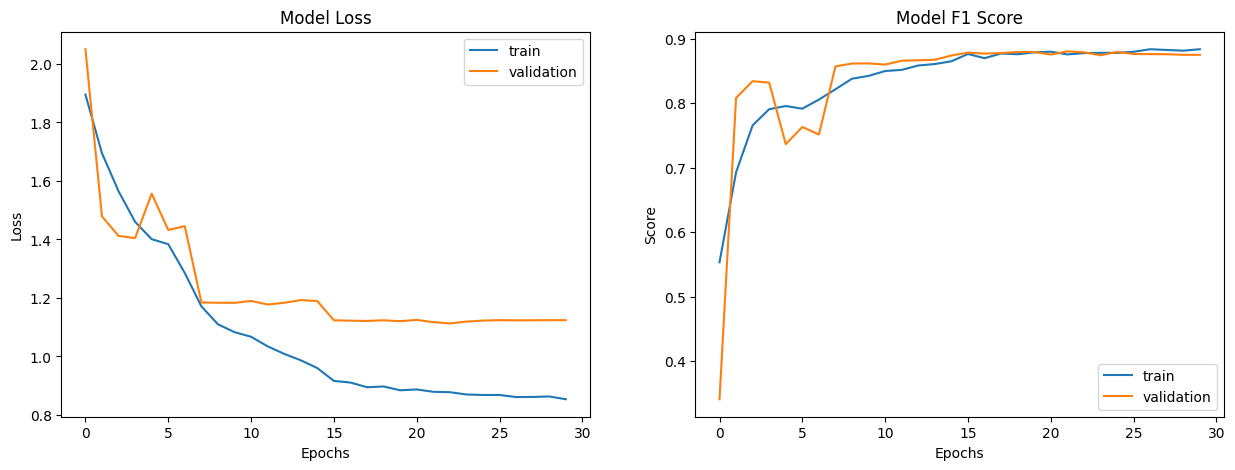

In [ ]:
evaluate_model_train(history_EX_easy, "Bi_output_F1Score")

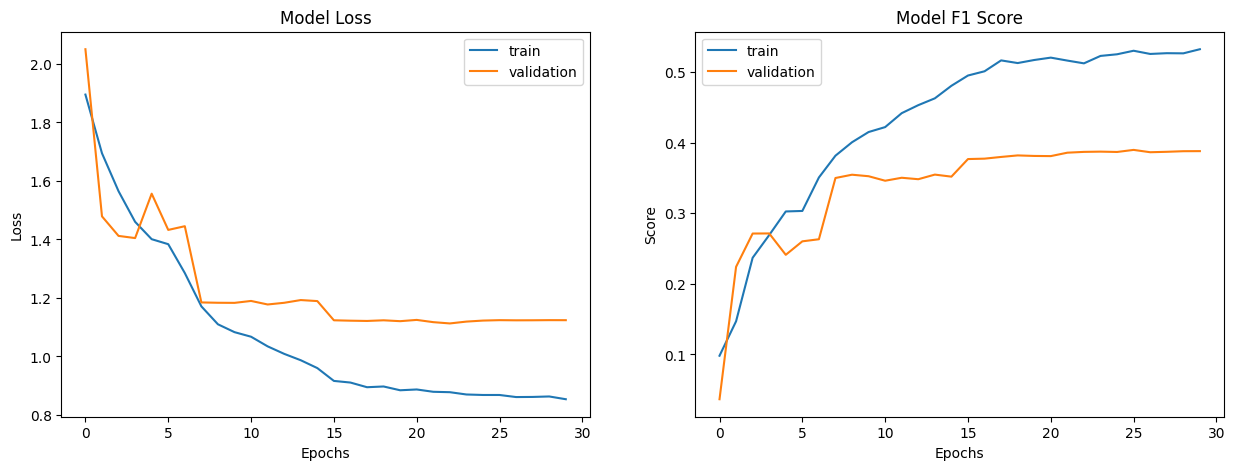

In [ ]:
evaluate_model_train(history_EX_easy, "MC_output_F1Score")

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Classification Report: Multiclass
              precision    recall  f1-score   support

      benign       0.81      0.86      0.84       396
   malignant       0.94      0.91      0.92       870

    accuracy                           0.89      1266
   macro avg       0.87      0.89      0.88      1266
weighted avg       0.90      0.89      0.90      1266



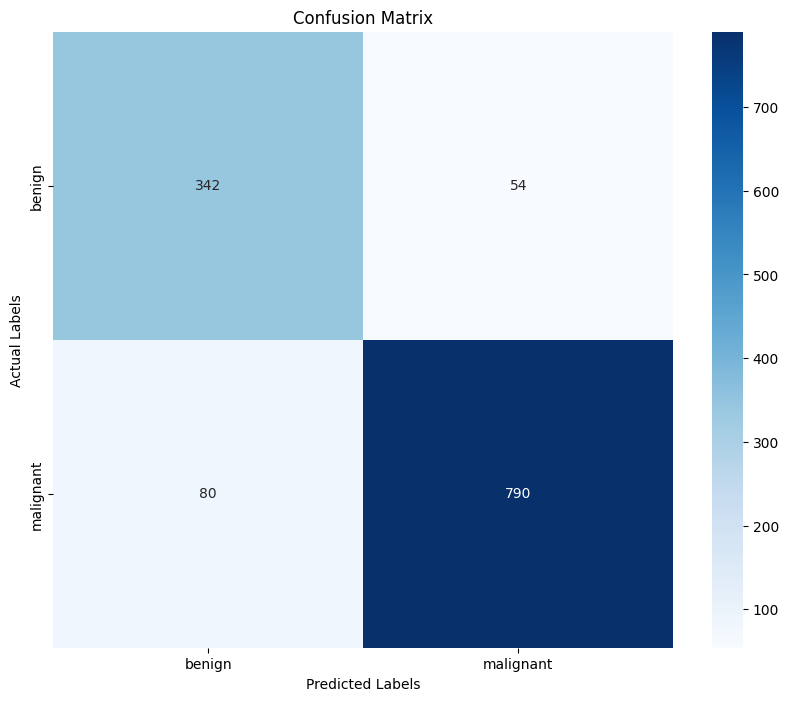

------------------------------------------------------------------------
Classification Report: Multiclass
                     precision    recall  f1-score   support

           adenosis       0.46      0.55      0.50        71
   ductal_carcinoma       0.83      0.49      0.62       553
       fibroadenoma       0.41      0.22      0.29       163
  lobular_carcinoma       0.29      0.72      0.41       100
 mucinous_carcinoma       0.29      0.20      0.23       127
papillary_carcinoma       0.25      0.47      0.32        90
    phyllodes_tumor       0.23      0.45      0.30        71
    tubular_adenoma       0.37      0.49      0.42        91

           accuracy                           0.44      1266
          macro avg       0.39      0.45      0.39      1266
       weighted avg       0.55      0.44      0.46      1266



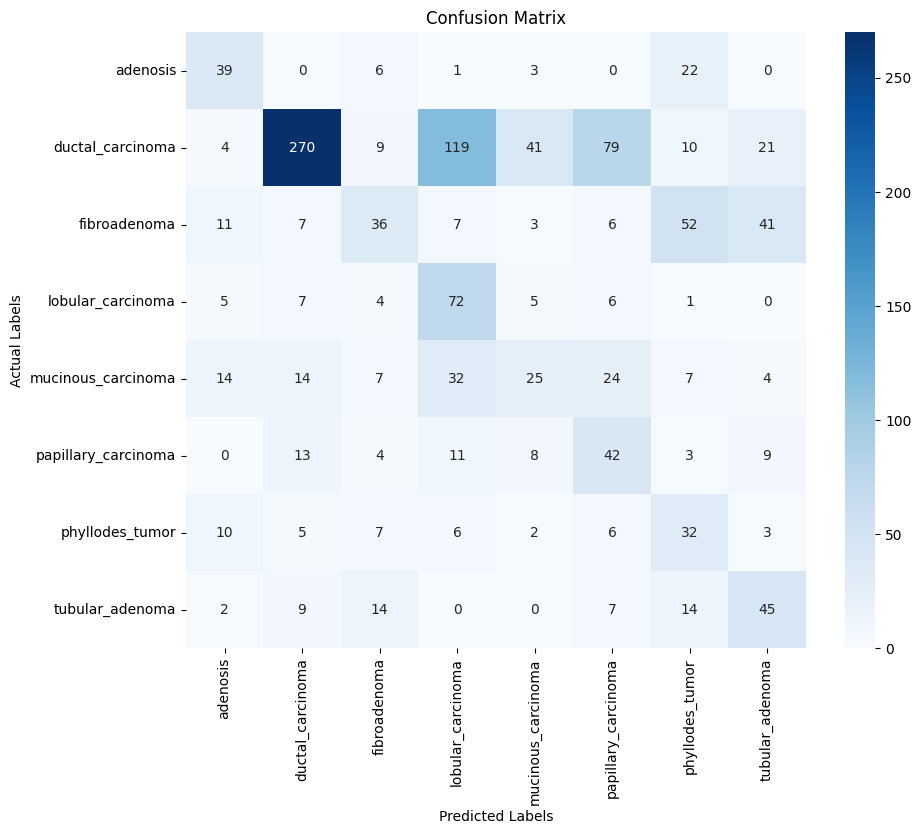

In [ ]:
evaluate_model_predictions(model=model_EX_easy,
                           X_array=val_data_dic_in,
                           y_array_1=y_binary_val_hp,
                           y_label_1=y_binary_labels,
                           problem_type='both',
                           y_array_2=y_multiclass_val_hp,
                           y_label_2=y_multiclass_labels)

This base model achieves a solid result of 0.88 F1 score on validation with no overfitting in the binary part; in the multiclass part it achieves a 0.39 F1 score on validation with overfitting. We will see if we can improve it.

### Advanced Model

This model follow the same concept as the one above, the only difference is that in the middle we will implement an inception module to try to capture features of different scales, as it is said in the article of its creation (<a href=" https://arxiv.org/pdf/1409.4842">Going deeper with convolutions</a>), “Another practically useful aspect of this design is that it aligns with the intuition that visual information should be processed at various scales and then aggregated so that the next stage can abstract features from different scales simultaneously”.

In [ ]:
# Model Advanced

# Inputs
input_tensor = Input(shape=shape_input, name='image')
input_magnitude = Input(shape=shape_mag, name='magnitude')

# Conv + Pool
Conv_3_3 = Conv2D(32, (3,3), activation='relu', name='Conv_3x3_1')(input_tensor)
Conv_3_3 = Conv2D(32, (3,3), activation='relu', name='Conv_3x3_2')(Conv_3_3)

Pool_2_2 = MaxPooling2D((2,2), name='Pool_2x2')(Conv_3_3)

# inception modules
block_1 = inception_module(Pool_2_2, n_f_1x1=64, n_f_3x3_r =16, n_f_3x3=64, n_f_5x5_r=16, n_f_5x5=64, n_f_1x1_end=64, name='IB1')

Pool2_2_2 = MaxPooling2D((2,2), name='Pool2_2x2')(block_1)

# Conv + Pool
Conv2_3_3 = Conv2D(64, (3,3), activation='relu', name='Conv2_3x3_1')(Pool2_2_2)
Conv2_3_3 = Conv2D(64, (3,3), activation='relu', name='Conv2_3x3_2')(Conv2_3_3)

Pool3_2_2 = MaxPooling2D((3,3), name='Pool3_2x2')(Conv2_3_3)

# Flaten bin
flat = Flatten(name='Flat')(Pool3_2_2)
flat = concatenate([flat, input_magnitude], axis=1, name='Flat_Bi')

# Dense Bi
Bi_dense = Dense(2048, activation='relu', name='Bi_dense0')(flat)
Bi_dense = Dropout(0.5, name='Bi_dropout0')(Bi_dense)
Bi_dense = Dense(1024, activation='relu', name='Bi_dense1')(Bi_dense)
Bi_dense = Dropout(0.5, name='Bi_dropout1')(Bi_dense)
Bi_dense = Dense(512, activation='relu', name='Bi_dense3')(Bi_dense)
Bi_dense = Dropout(0.4, name='Bi_dropout3')(Bi_dense)
Bi_output = Dense(2, activation='softmax', name='Bi_output')(Bi_dense)

# Flaten MC
flat_MC = concatenate([flat, Bi_output], name='Flat_MC', axis=1)

# Dense MC
MC_dense = Dense(8192, activation='relu', name='MC_dense1')(flat_MC)
MC_dense = Dropout(0.5, name='MC_dropout1')(MC_dense)
MC_dense = Dense(4096, activation='relu', name='MC_dense2')(MC_dense)
MC_dense = Dropout(0.5, name='MC_dropout2')(MC_dense)
MC_dense = Dense(2048, activation='relu', name='MC_dense3')(MC_dense)
MC_dense = Dropout(0.5, name='MC_dropout3')(MC_dense)
MC_dense = Dense(1024, activation='relu', name='MC_dense4')(MC_dense)
MC_dense = Dropout(0.4, name='MC_dropout4')(MC_dense)
MC_output = Dense(8, activation='softmax', name='MC_output')(MC_dense)

# build de model
model_EX_Adv = Model([input_tensor,input_magnitude], [Bi_output, MC_output])

model_EX_Adv.compile(optimizer='adam',
                 loss={'Bi_output' : 'categorical_crossentropy',
                        'MC_output' : 'categorical_crossentropy'},
                 loss_weights={'Bi_output' : 0.2,
                              'MC_output' : 0.8},
                 metrics={'Bi_output' : 'F1Score',
                        'MC_output' : 'F1Score'})

model_EX_Adv.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)        │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv_3x3_1 (Conv2D)       │ (None, 148, 148, 32)   │            896 │ image[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv_3x3_2 (Conv2D)       │ (None, 146, 146, 32)   │          9,248 │ Conv_3x3_1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Pool_2x2 (MaxPooling2D)   │ (None, 73, 73, 32)     │              0 │ Conv_3x3_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ IB1_Conv_3x3_r (Conv2D)   │ (None, 73, 73, 16)     │            528 │ Pool_2x2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ IB1_Conv_5x5_r (Conv2D)   │ (None, 73, 73, 16)     │            528 │ Pool_2x2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ IB1_Pool_3x3              │ (None, 73, 73, 32)     │              0 │ Pool_2x2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ IB1_Conv_1x1 (Conv2D)     │ (None, 73, 73, 64)     │          2,112 │ Pool_2x2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ IB1_Conv_3x3 (Conv2D)     │ (None, 73, 73, 64)     │          9,280 │ IB1_Conv_3x3_r[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ IB1_Conv_5x5 (Conv2D)     │ (None, 73, 73, 64)     │         25,664 │ IB1_Conv_5x5_r[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ IB1_Conv_1x1_end (Conv2D) │ (None, 73, 73, 64)     │          2,112 │ IB1_Pool_3x3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 73, 73, 256)    │              0 │ IB1_Conv_1x1[0][0],    │
│                           │                        │                │ IB1_Conv_3x3[0][0],    │
│                           │                        │                │ IB1_Conv_5x5[0][0],    │
│                           │                        │                │ IB1_Conv_1x1_end[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Pool2_2x2 (MaxPooling2D)  │ (None, 36, 36, 256)    │              0 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv2_3x3_1 (Conv2D)      │ (None, 34, 34, 64)     │        147,520 │ Pool2_2x2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv2_3x3_2 (Conv2D)      │ (None, 32, 32, 64)     │         36,928 │ Conv2_3x3_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Pool3_2x2 (MaxPooling2D)  │ (None, 10, 10, 64)     │              0 │ Conv2_3x3_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Flat (Flatten)            │ (None, 6400)           │              0 │ Pool3_2x2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ magnitude (InputLayer

 Total params: 112,517,962 (429.22 MB)

 Trainable params: 112,517,962 (429.22 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

LR_ajust = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3)

list_callbacks = [early_stop, LR_ajust]

In [ ]:
history_EX_adv = model_EX_Adv.fit(x_data,
                          y_data,
                          batch_size= 100,
                          epochs=50,
                          callbacks=list_callbacks,
                          validation_data=[val_data_dic_in, val_data_dic_out],
                          sample_weight=weights
                          )

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 77s 882ms/step - Bi_output_F1Score: 0.4684 - Bi_output_loss: 0.1403 - MC_output_F1Score: 0.0926 - MC_output_loss: 1.7667 - loss: 1.9070 - val_Bi_output_F1Score: 0.3755 - val_Bi_output_loss: 0.1415 - val_MC_output_F1Score: 0.0310 - val_MC_output_loss: 1.7390 - val_loss: 1.8812 - learning_rate: 0.0010
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 13s 258ms/step - Bi_output_F1Score: 0.5007 - Bi_output_loss: 0.1285 - MC_output_F1Score: 0.1072 - MC_output_loss: 1.6702 - loss: 1.7987 - val_Bi_output_F1Score: 0.8040 - val_Bi_output_loss: 0.0916 - val_MC_output_F1Score: 0.1750 - val_MC_output_loss: 1.4059 - val_loss: 1.5003 - learning_rate: 0.0010
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 262ms/step - Bi_output_F1Score: 0.7415 - Bi_output_loss: 0.1088 - MC_output_F1Score: 0.1625 - MC_output_loss: 1.5938 - loss: 1.7025 - val_Bi_output_F1Score: 0.8397 - val_Bi_output_loss: 0.0795 - val_MC_output_F1Score: 0.1797 - val_MC_output_loss: 1.3444 - val_loss: 1.4256 - learn

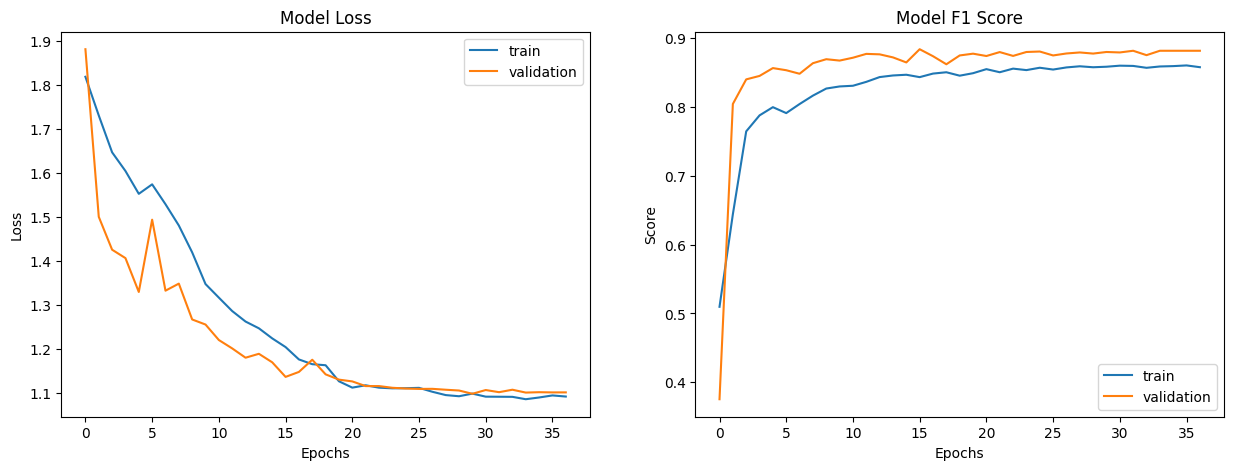

In [ ]:
evaluate_model_train(history_EX_adv, "Bi_output_F1Score")

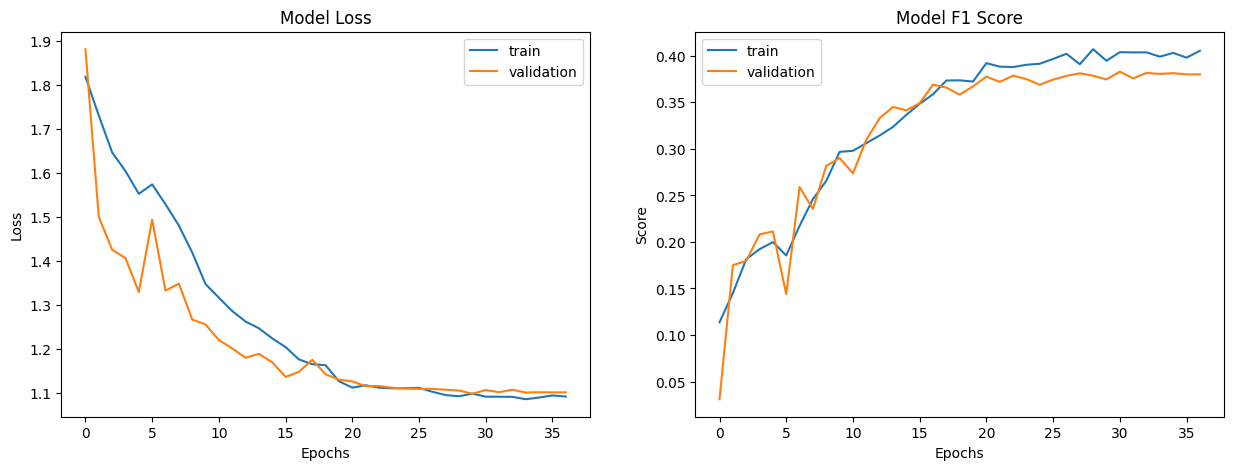

In [ ]:
evaluate_model_train(history_EX_adv, "MC_output_F1Score")

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step
Classification Report: Multiclass
              precision    recall  f1-score   support

      benign       0.79      0.90      0.84       396
   malignant       0.95      0.89      0.92       870

    accuracy                           0.89      1266
   macro avg       0.87      0.89      0.88      1266
weighted avg       0.90      0.89      0.89      1266



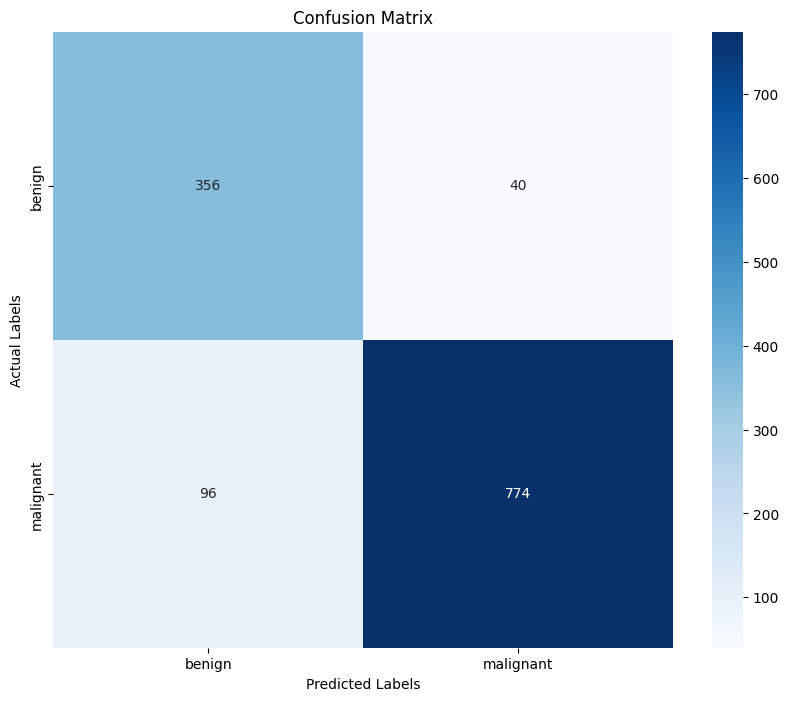

------------------------------------------------------------------------
Classification Report: Multiclass
                     precision    recall  f1-score   support

           adenosis       0.44      0.58      0.50        71
   ductal_carcinoma       0.82      0.45      0.58       553
       fibroadenoma       0.40      0.14      0.21       163
  lobular_carcinoma       0.28      0.75      0.41       100
 mucinous_carcinoma       0.43      0.17      0.25       127
papillary_carcinoma       0.23      0.57      0.32        90
    phyllodes_tumor       0.23      0.34      0.27        71
    tubular_adenoma       0.36      0.64      0.46        91

           accuracy                           0.43      1266
          macro avg       0.40      0.45      0.37      1266
       weighted avg       0.56      0.43      0.44      1266



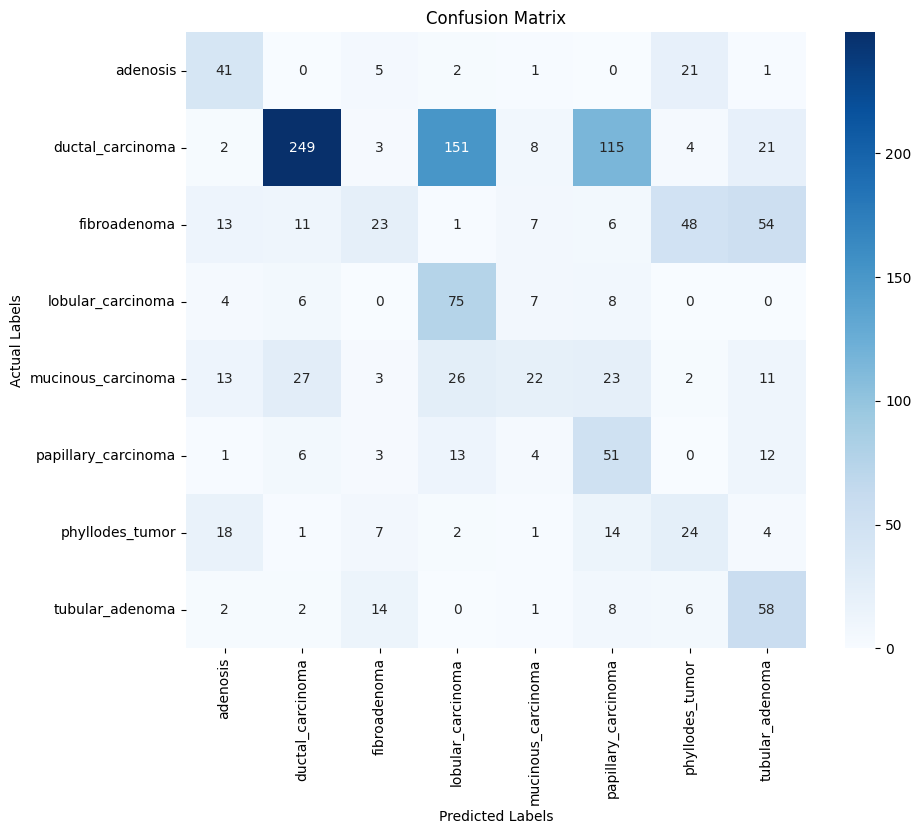

In [ ]:
evaluate_model_predictions(model=model_EX_Adv,
                           X_array=val_data_dic_in,
                           y_array_1=y_binary_val_hp,
                           y_label_1=y_binary_labels,
                           problem_type='both',
                           y_array_2=y_multiclass_val_hp,
                           y_label_2=y_multiclass_labels)

This advanced model achieves a result of 0.88 F1 score on validation with a little overfitting in the binary part; in the multiclass part it achieves a 0.37 F1 score on validation with no overfitting. We consider it better since it has less overfitting overall, compared to the base model.

So, we conclude the following, using the validation data, the benchmark is:
+ For Binary: 0.88 F1 score.
+ For multiclass: 0.37 F1 score.


## Final Evaluation on Test

In [ ]:
X_test_data = {'image' : X_test_a,
            'magnitude' : Mag_test}

50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step
Classification Report: Multiclass
              precision    recall  f1-score   support

      benign       0.75      0.87      0.81       496
   malignant       0.94      0.87      0.90      1086

    accuracy                           0.87      1582
   macro avg       0.84      0.87      0.85      1582
weighted avg       0.88      0.87      0.87      1582



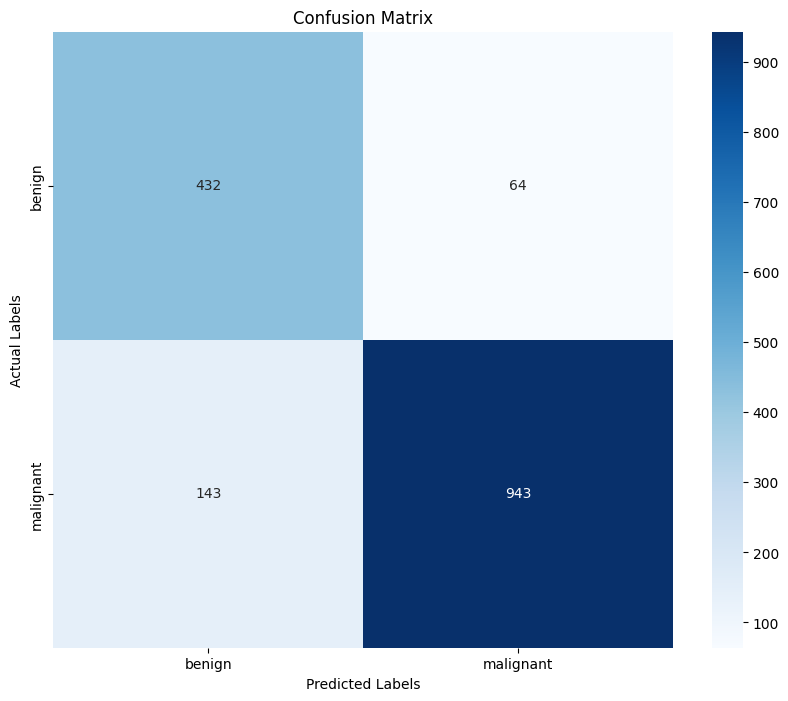

------------------------------------------------------------------------
Classification Report: Multiclass
                     precision    recall  f1-score   support

           adenosis       0.38      0.60      0.47        89
   ductal_carcinoma       0.82      0.44      0.58       691
       fibroadenoma       0.50      0.18      0.26       203
  lobular_carcinoma       0.27      0.72      0.39       125
 mucinous_carcinoma       0.55      0.21      0.30       158
papillary_carcinoma       0.20      0.53      0.29       112
    phyllodes_tumor       0.19      0.29      0.23        90
    tubular_adenoma       0.42      0.66      0.52       114

           accuracy                           0.43      1582
          macro avg       0.42      0.45      0.38      1582
       weighted avg       0.58      0.43      0.44      1582



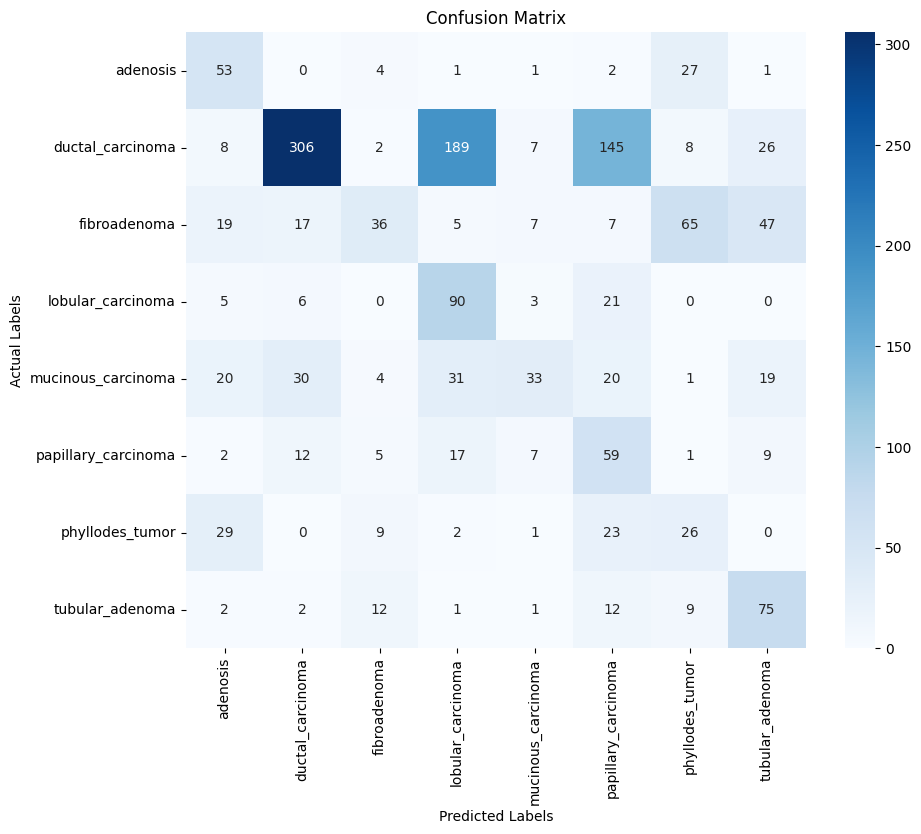

In [ ]:
evaluate_model_predictions(model=model_EX_Adv,
                           X_array=X_test_data,
                           y_array_1=y_binary_test,
                           y_label_1=y_binary_labels,
                           problem_type='both',
                           y_array_2=y_multiclass_test,
                           y_label_2=y_multiclass_labels)

So, we conclude the following, using the test data, the benchmark is:
+ For Binary: 0.85 F1 score.
+ For multiclass: 0.38 F1 score.

If we find a better model than that, we will use that as our final solution, if not, then this advanced model will be the one that we will use.

## Next Step
Go to the Binary and Multiclass notebooks to see the process of trying to find a model that is better at classifying than this one.